In [1]:
!pip install numpy torch statsmodels matplotlib seaborn

In [0]:
import numpy as np
import torch
import torch.distributions as dist

from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# MCMC

## Metropolis-Hastings rejection

Let $\pi(\theta)$ be the distribution from which we want to sample. Suppose we are given unnormalized density $\hat{\pi}(\theta) = \frac{\pi(\theta)}{Z}$ where $Z$ is the normalizing constant. In MCMC methods we choose proposal density $q(\theta' \mid \theta)$, initial point $\theta_0$ and then we build a Markov chain like that:

For $t = 0, 1,\dots$: 
1. sample $\hat{\theta}_{t+1} \sim q(\theta' \mid \theta_t)$
2. Apply Metropolis-Hastings rejection:
$$\theta_{t+1} = \begin{cases}
\hat{\theta}_{t+1}, \text{ with probabilty } \rho(\hat{\theta}_{t+1} \mid \theta_t) \\
\theta_t, \text{ with probabilty } 1 - \rho(\hat{\theta}_{t+1} \mid \theta_t)
\end{cases}$$
where 
$$\rho(\theta' \mid \theta) = \min \left(1, \frac{\hat{\pi}(\theta')q(\theta \mid \theta')}{\hat{\pi}(\theta)q(\theta' \mid \theta)} \right)$$

Below you can see Python class for MCMC method. You need to implement `acceptance_prob` method which computes $\rho(\theta' \mid \theta)$. Everything else is already implemented for you.

In [0]:
class Distribution:
    """Abstract class for unnormalized distribution"""
    
    def log_density(self, x):
        """
            Computes vectorized log of unnormalized log density
            
            x (torch tensor of shape BxD): B points at which we compute log density
            returns (torch tensor of shape B): \log \hat{\pi}(x) 
        """
        raise NotImplementedError
        
    def grad_log_density(self, x):
        """
            Computes vectorized gradient \nabla_x \log \pi(x)
            
            x (torch tensor of shape BxD): point at which we compute \nabla \log \pi
            returns (torch.tensor of shape BxD): gradients of log density
        """
        x = x.clone().requires_grad_()
        logp = self.log_density(x)
        logp.sum().backward()
        return x.grad

class Proposal:
    """Abstract class for proposal"""
    
    def sample(self, x):
        """
            Computes vectorized sample from proposal q(x' | x)
            
            x (torch tensor of shape BxD): current point from which we propose
            returns: (torch tensor of shape BxD) new points
        """
        raise NotImplementedError

    def log_density(self, x, x_prime):
        """
            Computes vectorized log of unnormalized log density
            
            x (torch tensor of shape BxD): B points at which we compute log density
            returns (torch tensor of shape B): \log q(x' | x) 
        """
        raise NotImplementedError
        
class MCMC:
    def __init__(self, distribution, proposal):
        """
            Constructs MCMC sampler
        
            distribution (Distribution): distribution from which we sample
            proposal (Proposal): MCMC proposal
        """
        self.distribution = distribution
        self.proposal = proposal
    
    def _step(self, x):
        x_prime = self.proposal.sample(x)
        acceptance_prob = self.acceptance_prob(x_prime, x)
        
        mask = torch.rand(x.shape[0]) < acceptance_prob
        x[mask] = x_prime[mask]
        self._rejected += (1 - mask).type(torch.float32)
        return x

    def simulate(self, initial_point, n_steps, n_parallel=10):
        """
            Run `n_parallel ` simulations for `n_steps` starting from `initial_point`
            
            initial_point (torch tensor of shape D): starting point for all chains
            n_steps (int): number of samples in Markov chain
            n_parallel (int): number of parallel chains
            returns: dict(
                points (torch tensor of shape n_parallel x n_steps x D): samples
                n_rejected (numpy array of shape n_parallel): number of rejections for each chain
                rejection_rate (float): mean rejection rate over all chains
                means (torch tensor of shape n_parallel x n_steps x D): means[c, s] = mean(points[c, :s])
                variances (torch tensor of shape n_parallel x n_steps x D): variances[c, s, d] = variance(points[c, :s, d])
            )
        """
        xs = []
        x = initial_point.repeat(n_parallel, 1)
        self._rejected = torch.zeros(n_parallel)
        
        dim = initial_point.shape[0]
        sums = np.zeros([n_parallel, dim])
        squares_sum = np.zeros([n_parallel, dim])
        
        means = []
        variances = []        
        
        for i in range(n_steps):
            x = self._step(x)
            xs.append(x.numpy().copy())
            
            sums += xs[-1]
            squares_sum += xs[-1]**2
            
            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)
        
        xs = np.stack(xs, axis=1)        
        means = np.stack(means, axis=1)
        variances = np.stack(variances, axis=1)
        
        return dict(
            points=xs,
            n_rejected=self._rejected.numpy(),
            rejection_rate=(self._rejected / n_steps).mean().item(),
            means=means,
            variances=variances
        )
        
    def acceptance_prob(self, x_prime, x):
        """
            In this function you need to compute 
            probability of acceptance \rho(x' | x)

            x_prime (numpy array): new point
            x (numpy array): current point
            returns: acceptance probability \rho(x', x)
        """
    
        # TODO
        pi_new = self.distribution.log_density(x_prime)
        pi_old = self.distribution.log_density(x)
        q_new = self.proposal.log_density(x_prime, x)
        q_old = self.proposal.log_density(x, x_prime)
        ratio = torch.exp(pi_new - pi_old + q_new - q_old)
        return ratio.clamp(0., 1.)
    
def simulate(distribution, proposal, initial_point, n_samples, n_parallel=10):
    mcmc = MCMC(distribution, proposal)
    return mcmc.simulate(initial_point, n_samples, n_parallel)

# Plotting utils

In [0]:
def plot_points(xs, ax, i=0, j=1, color=True):
    ax.set_title('points')
    ax.set_xlabel(f'coordinate {i}')
    ax.set_ylabel(f'coordinate {j}')
    
    n_parallel, n_samples, _ = xs.shape
    c = np.arange(n_samples) if color else None
    for k in range(n_parallel):
        ax.scatter(xs[k, :, i], xs[k, :, j], s=5, c=c)
    return ax

def plot_log_density(xs, ax, distribution):
    ax.set_title('log_density')
    ax.set_xlabel('iteration')
    ax.set_ylabel('log density')
    
    n_parallel, n_samples, _ = xs.shape
    for k in range(n_parallel):
        density = distribution.log_density(torch.tensor(xs[k]))
        ax.plot(density.numpy(), label=f'run {k + 1}')
    ax.legend(loc='best')
    return ax

def find_first(X):
    for i in range(X.shape[0]):
        if X[i]:
            return i
    return -1
  
def integrated_autocorr(x, acf_cutoff=0.0):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    n = len(x)

    tau = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        f = acf(x[:,j], nlags=n, unbiased=False, fft=True)
        window = find_first((f <= acf_cutoff).astype(np.uint8))
        tau[j] = 1 + 2*f[1:window].sum()

    return tau

def compute_ess(x, acf_cutoff=0.0):
    tau = integrated_autocorr(x, acf_cutoff=acf_cutoff)
    return x.shape[0] / tau
  
def plot_autocorr(xs, axes, step=100, mean=False, label=None):
    n_parallel, _, dim = xs.shape
    
    for i in range(dim):
        axes[i].set_title(f'autocorrelation (step={step}, coordinate {i})')
        axes[i].set_xlabel('lag')
        axes[i].set_ylabel('autocorrelation')
        
        acfs = [acf(xs[k, ::step, i]) for k in range(n_parallel)]
        ess = np.stack([compute_ess(xs[k]) for k in range(n_parallel)], axis=0)
        
        if mean:
            axes[i].plot(np.mean(acfs, axis=0), marker='o', label=(label or '') + f" ESS = {ess.mean(axis=0)[i]:.2f}")
        else:
            for k, acf_ in enumerate(acfs):
                axes[i].plot(acf_, marker='o', label=f'run {k} ESS = {ess[k][i]:.2f}')
            
        axes[i].legend(loc='best')
    return axes
        
def cummean(arr, axis=0):
    if axis < 0:
        axis = axis + len(arr.shape)
    
    arange = np.arange(1, arr.shape[axis] + 1)
    arange = arange.reshape((1,) * axis + (-1,) + (1,) * (len(arr.shape) - axis - 1))
    return arr.cumsum(axis=axis) / arange
    
def plot_statistics(xs, axes, skip=0, step=1):
    xs = xs[:, skip::step]
    n_parallel, _, dim = xs.shape
    
    means = cummean(xs, axis=1)
    variances = cummean(xs**2, axis=1) - means**2
    
    for i in range(n_parallel):
        for j in range(dim):
            ax = axes[j]
            ax.set_title(f'coordinate {j} running mean and std')
            ax.set_xlabel('iteration')
            ax.set_ylabel(f'coordinate {j}')
            
            x = np.arange(means.shape[1])
            y = means[i, :, j]
            e = np.sqrt(variances[i, :, j])
            
            r = ax.plot(y, label=f'chain {i} mean')
            ax.plot(e, linestyle='--', c=r[0].get_color(), label=f'chain {i} std')
            ax.legend(loc='best')
        
    return axes
  
def plot_traceplot(xs, axes):
    n_parallel, _, dim = xs.shape
    
    for i in range(n_parallel):
        for j in range(dim):
            ax = axes[j]
            ax.set_title(f'coordinate {j} traceplot')
            ax.set_xlabel('iteration')
            ax.set_ylabel(f'coordinate {j}')
           
            ax.plot(xs[i, :, j], label=f'chain {i}')
            ax.legend(loc='best')
        
    return axes

def plot_distribution(distribution, bounds, ax, num=50, n_levels=None, filled=False, exp=False):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    z = distribution.log_density(torch.tensor(xy, dtype=torch.float32)).numpy().reshape(s)
    if exp:
      z = np.exp(z)
    
    plot = ax.contourf if filled else ax.contour
    r = plot(x, y, z, n_levels)
    return ax, r

def plot_distribution_grad(distribution, bounds, ax, num=50):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
   
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    z = distribution.grad_log_density(torch.tensor(xy, dtype=torch.float32)).numpy()
    u, v = z[..., 0], z[..., 1]
    c = np.sqrt(u**2 + v**2)
    
    ax.quiver(x, y, u, v, c, angles='xy')
    return ax

# Distributions

In this seminar we consider four distributions on which we test different properties of MCMC methods.
1. Typical normal isotropic distribution: $$\pi(x) = \mathcal{N}(x \mid \mu, \sigma^2 I)$$
2. Scaled normal distribution: $$\pi(x) = \mathcal{N}(x \mid \mu, D)$$
3. Mixture of normals: $$\pi(x) = \frac{1}{N}\sum_{k=1}^N \mathcal{N}(x \mid \mu_k, D_k)$$
4. Langevin mixture: $$
\begin{align*}
    & \pi(\theta) = p(\theta \mid X) \propto p(X \mid \theta)p(\theta) \\
    & p(X \mid \theta) = \prod_{k=1}^N \left[ \frac{1}{2}\mathcal{N}(x_k \mid \theta_1, \sigma_x^2) + \frac{1}{2}\mathcal{N}(x_k \mid \theta_1 + \theta_2, \sigma_x^2) \right] \\
    & p(\theta) = \mathcal{N}(\theta_1 \mid 0, \sigma_1^2)\mathcal{N}(\theta_2 \mid 0, \sigma_2^2)
\end{align*}
$$ This is example is from [the paper](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf) on Langevin Dynamics.

**Hint:** mind the shape, `log_density` assumes that input is a batch of points (for running several parallel MCMC chains).

In [0]:
class Normal(Distribution):
    """Represents normal distribution N(mean, std)"""
    
    def __init__(self, loc, scale):
        """
            loc (torch tensor of shape D): mean
            scale (torch tensor of shape D) std
        """
        self.dist = dist.Normal(loc=loc, scale=scale)

    def log_density(self, x):
        return self.dist.log_prob(x).sum(dim=-1)
    

class MixtureOfNormals(Distribution):
    """Represents mixture of normals: \pi(x) = \sum_k \pi_k N(x | mean_k, std_k)"""
    def __init__(self, locs, scales, pi):
        """
            locs (torch tensor of shape NxD): locs[k] = mean_k
            scales (torch tensor of shape NxD): scales[k] = std_k
            pi (torch.tensor of shape N): pi[k] = pi_k
        """
        self.dists = [
            dist.Normal(loc=loc, scale=scale)
            for loc, scale in zip(locs, scales)
        ]
        self.pi = pi
        
    def log_density(self, x):
        log_densities = torch.stack([
            d.log_prob(x).sum(dim=-1)
            for d in self.dists
        ], dim=0)
        return torch.logsumexp(torch.log(self.pi).view(-1, 1) + log_densities, dim=0)

    
class LangevinMixture(Distribution):
    """
        This distribution is defined as posterior on theta_1, theta_2 given
        prior: theta_1 ~ N(0, \sigma_1^2), theta_2 ~ N(0, \sigma_2^2)
        likelihood: x_i ~ 0.5 * N(theta_1, \sigma_x^2) + 0.5 * N(theta_1 + theta_2, \sigma_x^2)
        
        More detailed information can be found at 
        https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf
    """
    
    def __init__(self, theta1=0., theta2=1., 
                       s1=np.sqrt(10.), s2=1., sx=np.sqrt(2.), N=100):
        mu = torch.tensor([theta1, theta1 + theta2])
        pi = np.random.binomial(n=1, p=0.5, size=N).astype(np.int64)

        d = dist.Normal(loc=mu, scale=sx)
        self.X = d.sample((N,))[np.arange(N), pi]
    
        self.d1 = dist.Normal(loc=0., scale=s1)
        self.d2 = dist.Normal(loc=0., scale=s2)
        self.dx = dist.Normal(loc=0., scale=sx)
    
    def log_density(self, theta):
        theta1, theta2 = theta[..., 0], theta[..., 1]
        log_prior = self.d1.log_prob(theta1) + self.d2.log_prob(theta2)
        
        mu = torch.stack([theta1, theta1 + theta2], dim=-1)
        
        log_likelihood = self.dx.log_prob(self.X[None, :, None] - mu[:, None])
        log_likelihood = torch.logsumexp(log_likelihood, dim=-1)
        return log_prior + log_likelihood.sum(dim=-1)

# Proposals

We will study three proposal distributions.

1. Random walk:
$$q(\theta' \mid \theta) = \mathcal{N}(\theta' \mid \theta, \sigma^2)$$
2. Langevin dynamics:
$$q(\theta' \mid \theta) = \mathcal{N}\left(\theta' \mid \theta - \frac{\varepsilon}{2}\nabla \log \pi(\theta), \varepsilon \right)$$
3. Hamiltonian Monte-Carlo (HMC):
$$
\begin{align*}
    & r \sim \mathcal{N}(0, I) \\
    & \theta', r' = \text{integrate}(\theta, r)
\end{align*}
$$
Integrate refers to Hamiltonian dynamics:
$$
\begin{align*}
    & H(\theta, r) = -\log \pi(\theta) + \frac{1}{2}r^T r \\ 
    & \frac{d\theta}{dt} = \frac{\partial H}{\partial r} \\
    & \frac{dr}{dt} = -\frac{\partial H}{\partial \theta}
\end{align*}
$$

You need to implement all three proposals. For HMC you need to code different integration schemes. Here we take rather naive approach to HMC implementation. In practice you would use adaptive schemes like [NUTS](https://arxiv.org/abs/1111.4246).

In [0]:
class RandomWalk(Proposal):
    """Proposal of the form q(x' | x) = N(x' | x, \sigma^2)"""
    
    def __init__(self, sigma):
        self.sigma = sigma
        self.d = dist.Normal(loc=0., scale=sigma)
        
    def sample(self, x):
        return x + self.d.sample(sample_shape=x.shape)
    
    def log_density(self, x, x_prime):
        return self.d.log_prob(x_prime - x).sum()
    
    def __str__(self):
        return f"Random walk sigma={self.sigma}"
    
class Langevin(Proposal):
    """Proposal given by q(x' | x) = N(x' | x - 0.5 * eps * \nabla \log \pi(x), eps)"""
    def __init__(self, eps, d):
        self.d = dist.Normal(loc=0., scale=np.sqrt(eps))
        self.dist = d
        self.eps = eps
        
    def sample(self, x):
        return x - 0.5 * self.eps * self.dist.grad_log_density(x) + self.d.sample(sample_shape=x.shape)       
    
    def log_density(self, x, x_prime):
        xn = x - 0.5 * self.eps * self.dist.grad_log_density(x)
        return self.d.log_prob(x_prime - xn).sum(dim=-1)
    
    def __str__(self):
        return f"Langevin eps={self.eps}"

class HMC(Proposal):
    """HMC proposal"""
    
    def __init__(self, eps, d, n_steps=5, method='leapfrog'):
        self.d = dist.Normal(loc=0., scale=1.)
        self.dist = d
        self.eps = eps
        self.n_steps = n_steps
        self.method = method
        self._method = {
            'leapfrog': self._leapfrog,
            'euler': self._euler,
            'simple_euler': self._simple_euler
        }[method]
          
    def _energy(self, x, v):
        return -self.dist.log_density(x) + self.d.log_prob(v).sum(dim=-1)
        
    def _leapfrog(self, x, v):
        self.energy = []
        for _ in range(self.n_steps):
            v -= 0.5 * self.eps * self.dist.grad_log_density(x)
            x = x + self.eps * v
            v -= 0.5 * self.eps * self.dist.grad_log_density(x)
            self.energy.append(self._energy(x, v))
        return x, v
    
    def _euler(self, x, v):
        self.energy = []
        for _ in range(self.n_steps):
            v -= self.eps * self.dist.grad_log_density(x)
            x = x + self.eps * v
            self.energy.append(self._energy(x, v))
        return x, v
    
    def _simple_euler(self, x, v):
        self.energy = []
        for _ in range(self.n_steps):
            x, v = x + self.eps * v, v - self.eps * self.dist.grad_log_density(x)
            self.energy.append(self._energy(x, v))
        return x, v
        
    def sample(self, x):
        v = self.d.sample(sample_shape=x.shape)
        self.v0 = v.clone()
        self.x0 = x.clone()
        
        x, v = self._method(x, v)
        self.v = v
        return x
    
    def log_density(self, x, x_prime):
        if torch.norm(x - self.x0).item() < 1e-5:
            return self.d.log_prob(self.v0).sum(dim=-1)
        else:
            return self.d.log_prob(self.v).sum(dim=-1)
    
    def __str__(self):
        return f"HMC eps={self.eps}, n_steps={self.n_steps}, method={self.method}"

# Experiments

First of all, let's plot all the probability distributions to better understand what we deal with. Plots are in log-domain, pass `exp=True` to `plot_distribution` to have the real density

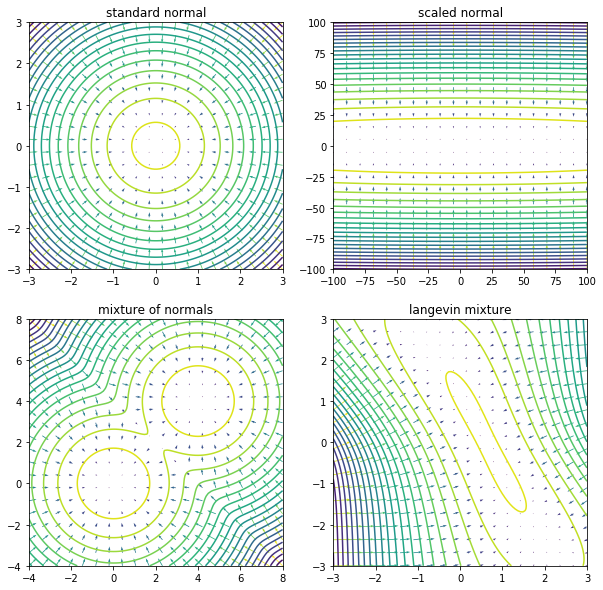

In [16]:
standard_normal = Normal(loc=0., scale=1.)
scaled_normal = Normal(loc=0., scale=torch.tensor([10., 1.]))
mixture = MixtureOfNormals(
    locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
    scales=[1., 1.],
    pi=torch.tensor([0.5, 0.5])
)

langevin = LangevinMixture()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
plot_distribution(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0][0], num=100, n_levels=20)
plot_distribution_grad(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0][0], num=20)
axes[0][0].set_title('standard normal')

plot_distribution(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[0][1], num=100, n_levels=20)
plot_distribution_grad(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[0][1], num=20)
axes[0][1].set_title('scaled normal')

plot_distribution(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[1][0], num=100, n_levels=20)
plot_distribution_grad(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[1][0], num=20)
axes[1][0].set_title('mixture of normals')

plot_distribution(langevin, bounds=((-3, 3), (-3, 3)), ax=axes[1][1], num=100, n_levels=20)
plot_distribution_grad(langevin, bounds=((-3, 3), (-3, 3)), ax=axes[1][1], num=20)
axes[1][1].set_title('langevin mixture');

## Sampler tuning

The most important issue when working with MCMC is the hyperparameter tuning. One useful quantity to track is rejection rate. Plot samples and rejection rate for different proposals and hyperparameters. What can you say about dependence of rejection rate and quality of sampling?

In [0]:
def tuning_experiment(distribution, proposal, hyperparameters, options, color=True):
    fig, axes = plt.subplots(ncols=len(hyperparameters), figsize=(20, 20))

    for i, hp in enumerate(hyperparameters):
        result = simulate(distribution, proposal(**hp), **options)
        ax = axes[i]
        plot_points(result['points'], ax, color=color)
        
        ax.set_aspect('equal')
        hp_string = ', '.join(f'{k}={v}' for k, v in hp.items())
        ax.set_title(f'{hp_string}, rejection rate = {result["rejection_rate"]:.2f}')
        ax.set_xlim(-4., 4.)
        ax.set_ylim(-4., 4.)

**Note:** by default `plot_points` makes the color of point brighter if it is the point from later iteration. You can see different chains by setting `color=False`.

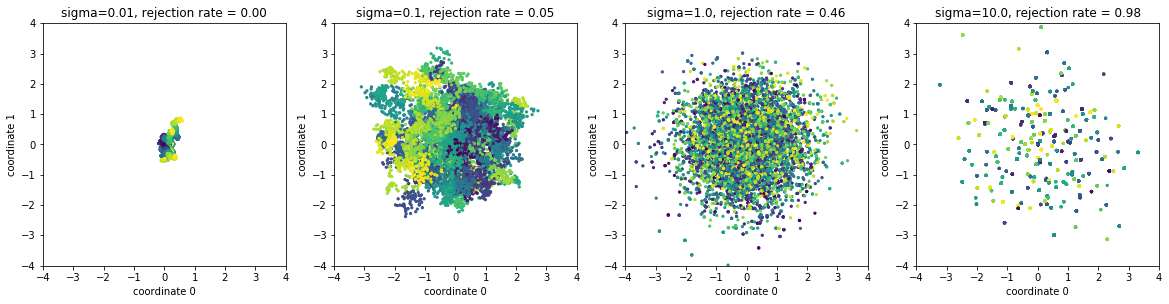

In [18]:
# choose some sigmas and run simulations
sigmas = [0.01, 0.1, 1.0, 10.]

tuning_experiment(
    standard_normal,
    proposal=RandomWalk,
    hyperparameters=[dict(sigma=s) for s in sigmas],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

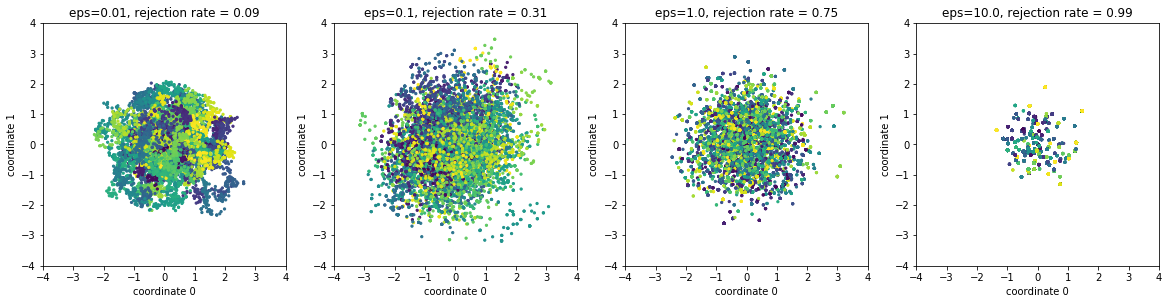

In [20]:
# choose some step sizes and run simulation
step_sizes = sigmas = [0.01, 0.1, 1.0, 10.]

proposal = lambda eps: Langevin(eps, d=standard_normal)

tuning_experiment(
    standard_normal,
    proposal=proposal,
    hyperparameters=[dict(eps=e) for e in step_sizes],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

## Scale of distribution

Use the same proposals but for the scaled normal distribution. How hyperparameters and number of samples necessary to cover the distribution changes.

In [0]:
def run_many_proposals(distribution, proposals, options, bounds=[(-40, 40), (-4, 4)]):
    fig, axes = plt.subplots(nrows=len(proposals), figsize=(20, 10))

    for i, proposal in enumerate(proposals):
        result = simulate(distribution, proposal, **options)
        ax = axes[i]
        plot_points(result['points'], ax)
        ax.set_title(f'{proposal}, rejection rate = {result["rejection_rate"]:.2f}')
        ax.set_xlim(*bounds[0])
        ax.set_ylim(*bounds[1])
        ax.set_aspect('equal')

    fig.tight_layout()

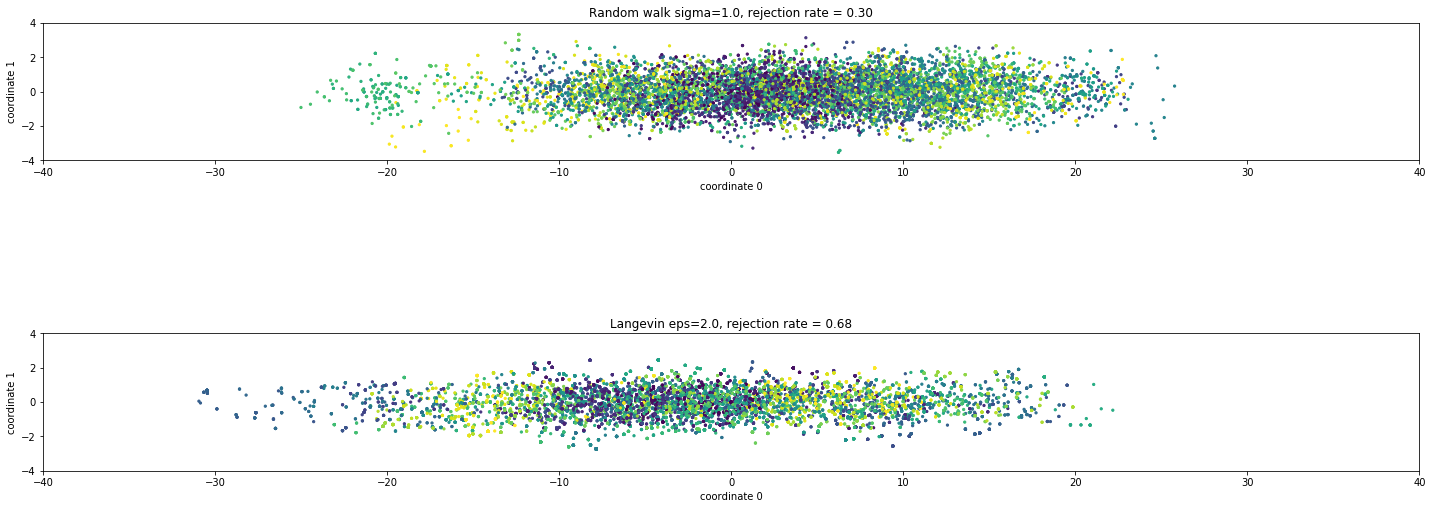

In [24]:
# Try out different proposals
proposals = [
        RandomWalk(1.0), 
        Langevin(2.0, d=scaled_normal)
]

run_many_proposals(
    scaled_normal,
    proposals=proposals,
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

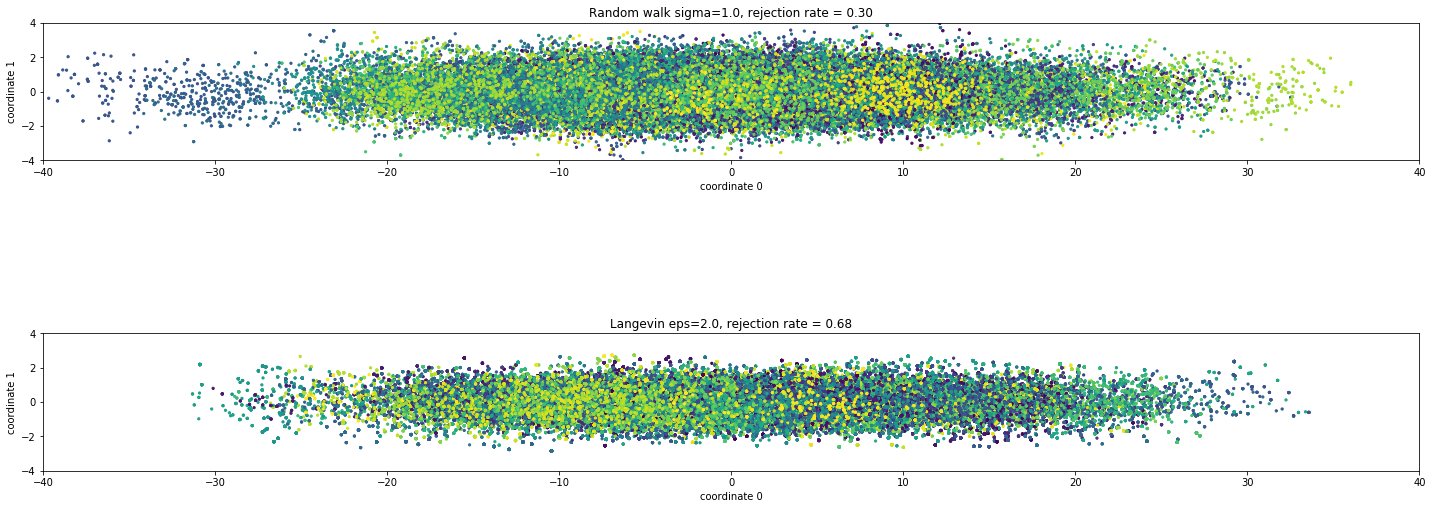

In [25]:
# Now with 10x more samples

run_many_proposals(
    scaled_normal,
    proposals=proposals,
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=10000,
        n_parallel=10
    )
)

## Autocorrelation

Another aspect which you can use to tune your sampler is the autocorrelation of the samples. Plot autocorrelation for different proposals. Also try to take every 10th or 100th sample and watch how autocorrelation changes. A useful thing to measure when working with MCMC is the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size) (ESS) which is defined as $$\text{ESS} = \frac{\text{number of samples}}{\text{autocorrelation time}}$$ 

In a nutshell, it says how many *almost uncorrelated* samples there are in chain. 

In [0]:
def autocorr_experiment(distribution, proposals, steps, options):
    fig, axes = plt.subplots(nrows=len(steps), ncols=options['initial_point'].shape[0], figsize=(20, 10))

    for proposal in proposals:
        result = simulate(distribution, proposal, **options)
        xs = result['points']
        
        for i, step in enumerate(steps):
            plot_autocorr(xs, axes[i], step=step, mean=True, label=f'{proposal}')
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    return fig

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


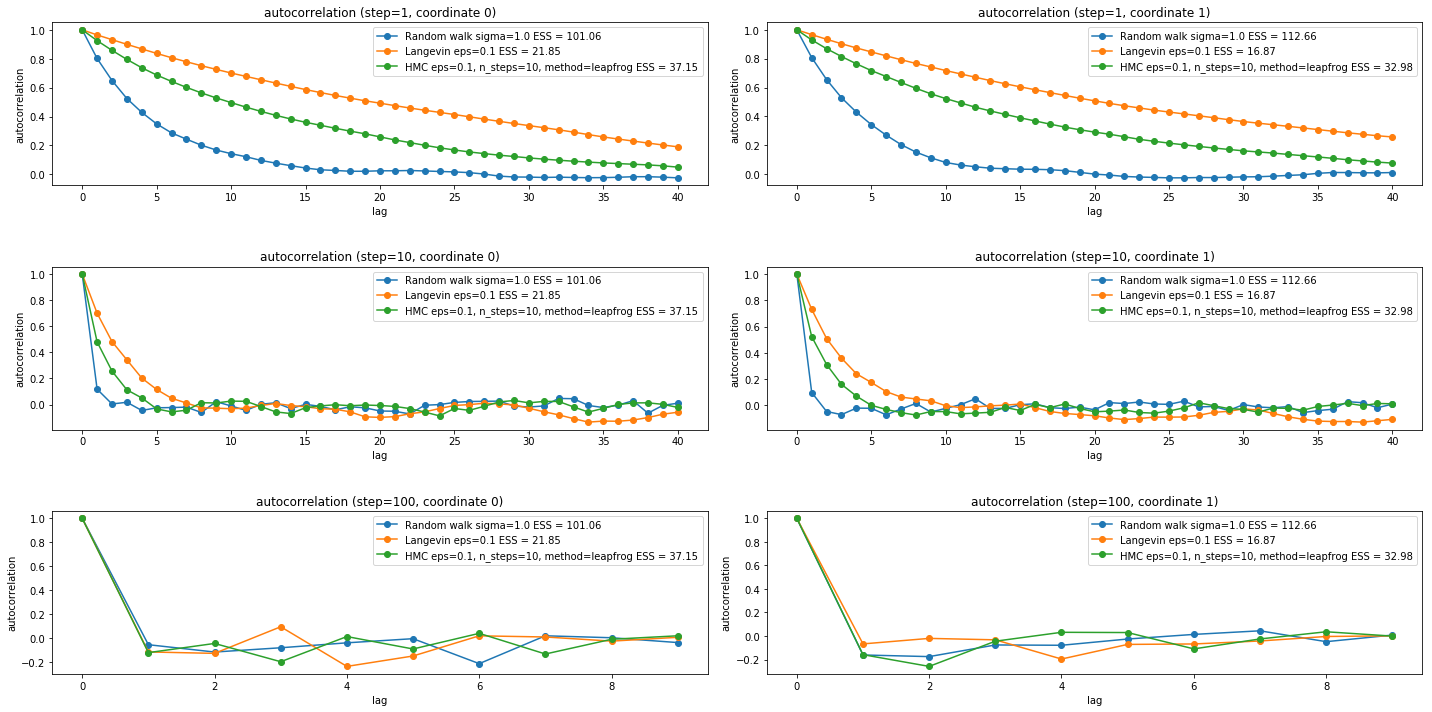

In [28]:
proposals = [
        RandomWalk(1.0),
        Langevin(0.1, d=standard_normal),
        HMC(0.1, d=standard_normal, n_steps=10)
]

autocorr_experiment(
    distribution=standard_normal,
    proposals=proposals,
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
);

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


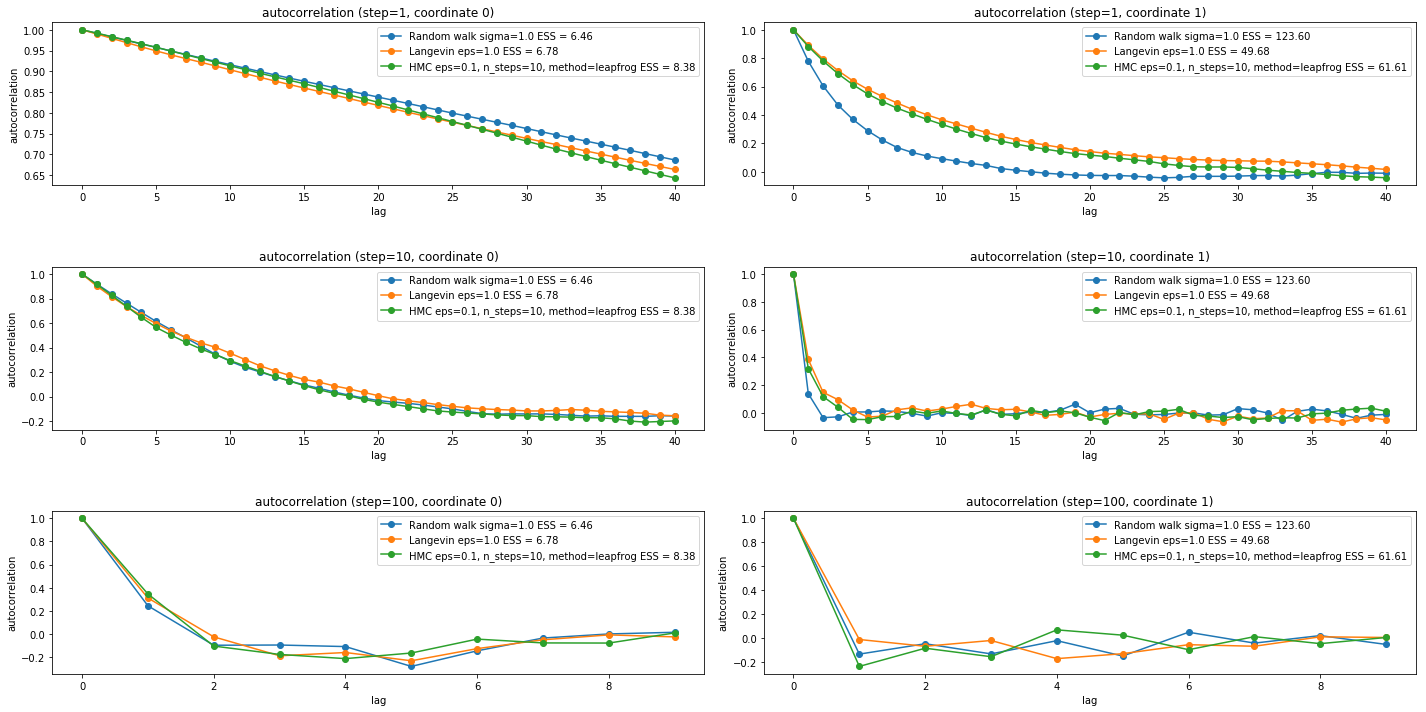

In [30]:
proposals = [
        RandomWalk(1.0),
        Langevin(1.0, d=scaled_normal),
        HMC(0.1, d=scaled_normal, n_steps=10)
]

autocorr_experiment(
    distribution=scaled_normal,
    proposals=proposals,
    steps=[1, 10, 100],
    options=dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
);

## Multi-modality

Research how MCMC deals with multimodal distributions. For Gaussian mixture start in one mode and try to reach the other. Watch how this changes with increasing distance between the modes.

### Gaussian mixture

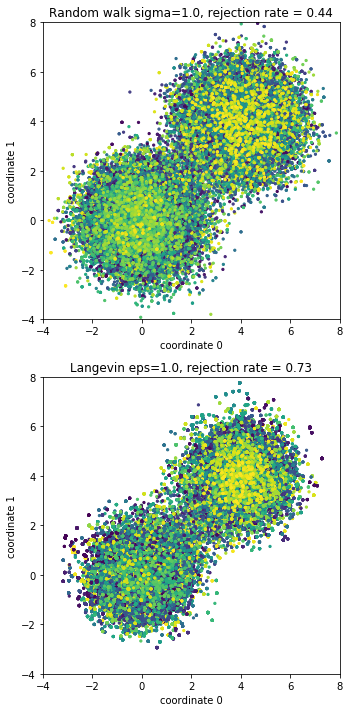

In [31]:
run_many_proposals(
    mixture,
    proposals=[
        RandomWalk(1.0), 
        Langevin(1.0, d=mixture)
    ],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=10000,
        n_parallel=10
    ),
    bounds=[(-4, 8), (-4, 8)]
)

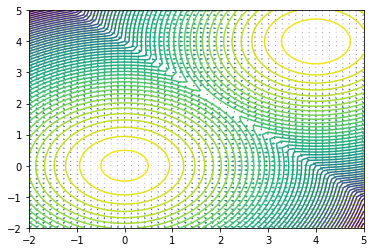

In [35]:
dst = MixtureOfNormals(
    locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
    scales=[0.4, 0.4],
    pi=torch.tensor([0.3, 0.7])
)
bnds = [(-2, 5), (-2, 5)]
plot_distribution(dst, bnds, plt.gca(), n_levels=50)
plot_distribution_grad(dst, bnds, plt.gca())

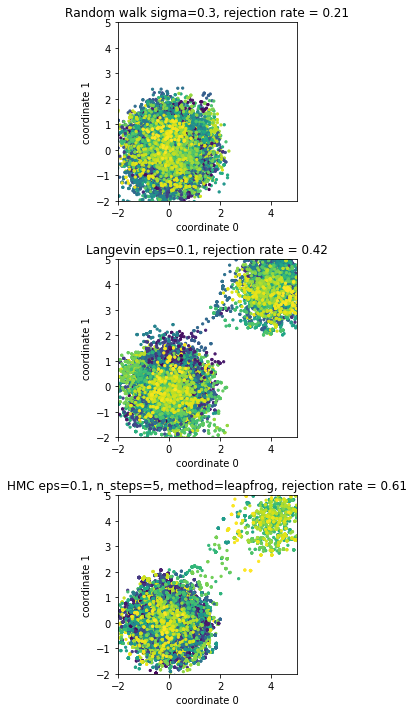

In [37]:
# Try changing the scales of mixture parts and observe how samples change

dst = MixtureOfNormals(
        locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
        scales=[0.7, 0.7],
        pi=torch.tensor([0.3, 0.7])
    )

run_many_proposals(
    dst,
    proposals=[
        RandomWalk(0.3), 
        Langevin(0.1, d=dst),
        HMC(0.1, d=dst)
    ],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=3000,
        n_parallel=10
    ),
    bounds=[(-2, 5), (-2, 5)]
)

### Langevin mixture

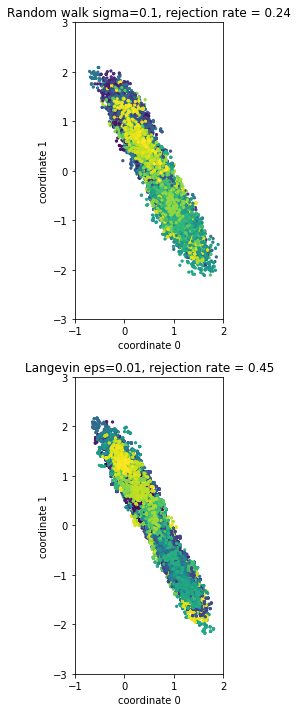

In [38]:
run_many_proposals(
    langevin,
    proposals=[
        RandomWalk(0.1), 
        Langevin(0.01, d=langevin)
    ],
    options = dict(
        initial_point=torch.tensor([0., 1.]),
        n_samples=3000,
        n_parallel=10
    ),
    bounds=[(-1, 2), (-3, 3)]
)

## Detection of convergence

In previous experiments we usually started from the mode of the distribution. This is not the case in many situations and in fact we might not even start from a typical point from the distribution. We need means to detect MCMC convergence. The easiest way to detect it by watching statistics of $N$ last samples and/or same statistics of different chains.

In [0]:
def convergence_detection_experiment(distribution, proposals, options, bounds=[(-2, 2), (-3, 3)]):
    D = options['initial_point'].shape[0]
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    gs = fig.add_gridspec(2 * len(proposals), 1 + D)

    for i, proposal in enumerate(proposals):
        result = simulate(distribution, proposal, **options)
        ax = [fig.add_subplot(gs[2*i:2*i+2, 0])] + [fig.add_subplot(gs[2*i, 1+k]) for k in range(D)] + [fig.add_subplot(gs[2*i+1, 1+k]) for k in range(D)]
        plot_points(result['points'], ax[0])
        plot_statistics(result['points'], ax[1:1 + D])
        plot_traceplot(result['points'], ax[1 + D: 1 + 2 * D])

        ax[0].set_title(f'{proposal}, rejection rate = {result["rejection_rate"]:.2f}')
        ax[0].set_xlim(*bounds[0])
        ax[0].set_ylim(*bounds[1])
        ax[0].set_aspect('equal')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


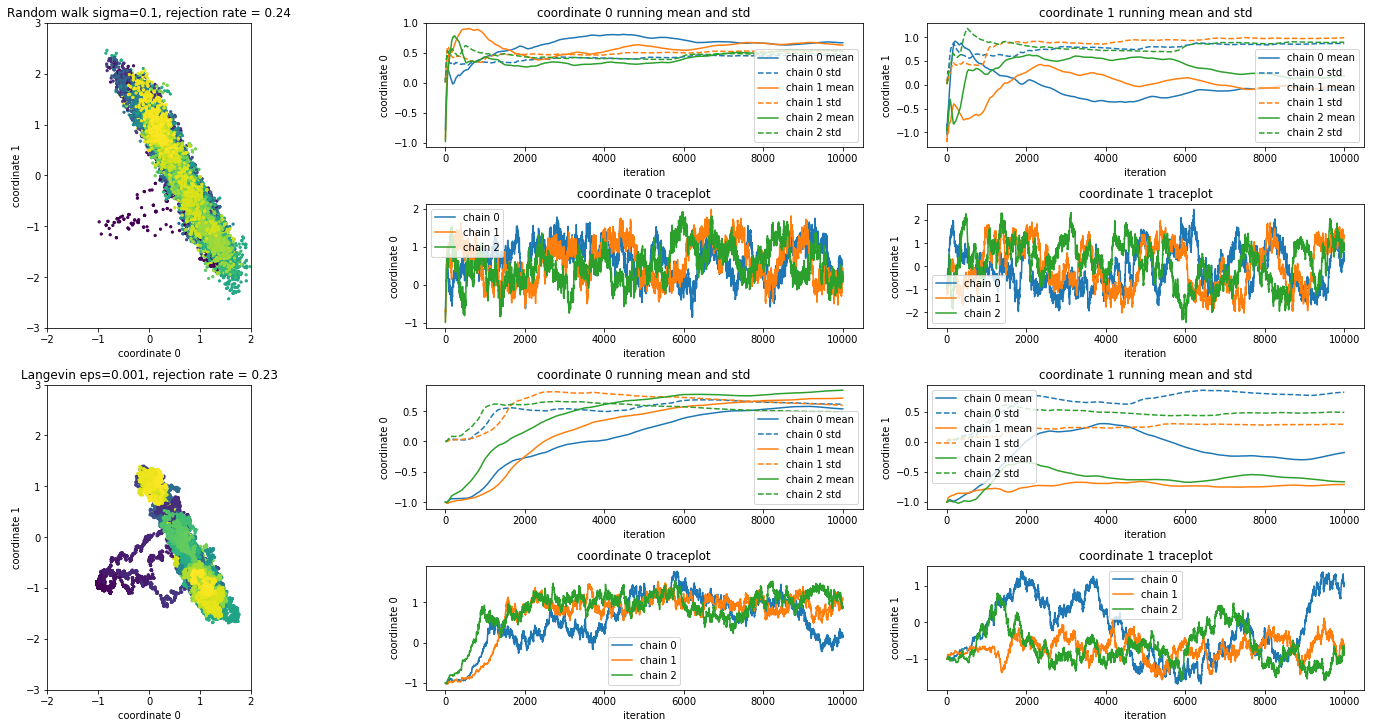

In [40]:
# Watch at plots of statistics and find the right amount of samples for MCMC to converge
# Try out different proposals

convergence_detection_experiment(
    langevin,
    proposals=[
        RandomWalk(0.1), 
        Langevin(0.001, d=langevin)
    ],
    options = dict(
        initial_point=torch.tensor([-1., -1.]),
        n_samples=10000,
        n_parallel=3
    )
);

## Centred/Non-centred parameterization

In many ways the parameterization of your model counts. Look at the following example (it is called Neal's funnel):

$$\begin{align*}
   & z \sim \mathcal{N}(0, 3) \\
   & x \sim \mathcal{N}(0, \exp(z/2))
\end{align*}$$

We can sample from this distribution over $(x, z)$ directly using MCMC. However this distribution is rather complex as you can see from figure below. Instead, we can reparameterize it like that:

$$\begin{align*}
   & \bar{z} \sim \mathcal{N}(0, 1) & z = \sqrt{3}\bar{z} \\
   & \bar{x} \sim \mathcal{N}(0, 1) & x = \exp{(z/4)}\bar{x} 
\end{align*}$$

The distribution over $(\bar{z}, \bar{x})$ is just a spherical normal which is very easy to sample from for MCMC methods. This is quite toy example, however parameterization of the model plays important role in efficiency of variational inference schemes.

You can find more about this issue in details [here](https://arxiv.org/pdf/1906.03028.pdf).

In [0]:
class Funnel(Distribution):
    def __init__(self):
        self.d = dist.Normal(loc=0., scale=np.sqrt(3.))
        
    def log_density(self, y):
        x, z = y[:, 0], y[:, 1]
        logp_z = self.d.log_prob(z).sum(dim=-1)
        logp_x = dist.Normal(loc=0., scale=z.mul(0.25).exp()).log_prob(x)
        return logp_z + logp_x

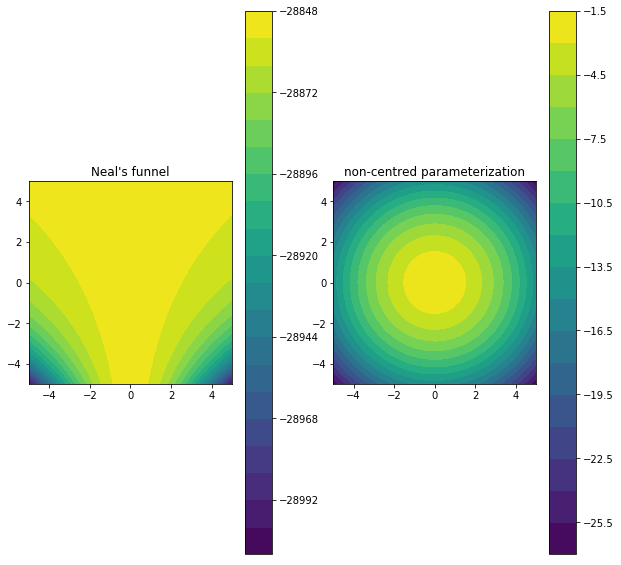

In [42]:
centred = Funnel()
noncentred = Normal(loc=0., scale=torch.tensor([1., 1.]))

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
r = plot_distribution(centred, bounds=((-5, 5), (-5, 5)), ax=axes[0], num=100, n_levels=20, filled=True)[1]
axes[0].set_title("Neal's funnel")
axes[0].set_aspect('equal')
fig.colorbar(r, ax=axes[0])

r = plot_distribution(noncentred, bounds=((-5, 5), (-5, 5)), ax=axes[1], num=100, n_levels=20, filled=True)[1]
axes[1].set_title('non-centred parameterization')
axes[1].set_aspect('equal')
fig.colorbar(r, ax=axes[1])

## Symplecticity

For HMC to work we need to employ some kind of integrator. Usually we use Leapfrog because it is symplectic second-order method. Try different methods and watch how error in Hamiltonian increases with number of integration steps. **Hint:** use `HMC.energy`.

In [0]:
options = dict(
    initial_point=torch.tensor([0., 0.]),
    n_samples=1000,
    n_parallel=5
)

base_eps = 0.05
steps = [1, 5, 10, 50]

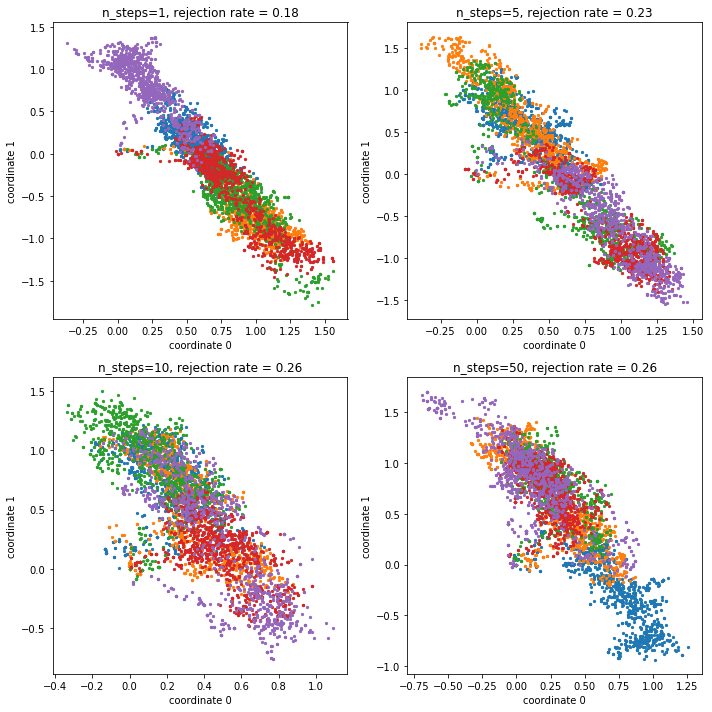

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
energies = []

for i, n_steps in enumerate(steps):
    proposal = HMC(eps=base_eps / n_steps, d=langevin, n_steps=n_steps, method='simple_euler')
    ax = axes[i // 2][i % 2]
    result = simulate(langevin, proposal, **options)
    plot_points(result['points'], ax, color=False)
    ax.set_title(f'n_steps={n_steps}, rejection rate = {result["rejection_rate"]:.2f}')
    en = np.stack([x.numpy() for x in proposal.energy], axis=0)
    energies.append(en)

fig.tight_layout()

0.0
0.012912309
0.036056142
0.015091243


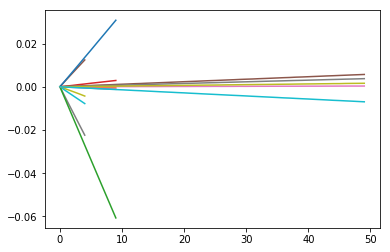

In [45]:
for en, n_steps in zip(energies, steps):
  plt.plot(en - en[:1, :], label=f"{n_steps}")
  print(np.sqrt(((en - en[:1, :])**2).sum(axis=0)).mean())